### Importing Modules

In [103]:
import torch
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import RobustScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import requests
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from utils import eo_grabber



### Loading data

In [81]:
url = "https://www.federalregister.gov/api/v1/documents.csv?fields[]=document_number&fields[]=executive_order_number&fields[]=president&fields[]=publication_date&fields[]=signing_date&fields[]=title&per_page=1000&order=newest&conditions[publication_date][gte]=2000&conditions[presidential_document_type][]=executive_order"

eo_grabber(url)

Data successfully written to federal_register_data.csv


In [104]:
df = pd.read_csv('federal_register_data.csv')
df.shape

(1000, 6)

### Exploratory Data Analysis

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 983 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   document_number         983 non-null    object        
 1   executive_order_number  983 non-null    float64       
 2   president               983 non-null    object        
 3   publication_date        983 non-null    datetime64[ns]
 4   signing_date            983 non-null    datetime64[ns]
 5   title                   983 non-null    object        
 6   signing_year            983 non-null    int32         
 7   political_party         983 non-null    object        
 8   serving_term            983 non-null    object        
 9   term_start              983 non-null    datetime64[ns]
 10  term_end                983 non-null    object        
 11  eo_title_length         983 non-null    int64         
 12  days_since_term_start   983 non-null    int64         


In [174]:
df.document_number.duplicated().any()

np.False_

### Data pre-processing

In [107]:

df['signing_date'] = pd.to_datetime(df['signing_date'], errors='coerce')
df['publication_date'] = pd.to_datetime(df['signing_date'], errors='coerce')

valid_diff = (df['publication_date'] - df['signing_date']).dt.days

median_diff = valid_diff.dropna().median()

df['signing_date'] = df['signing_date'].fillna(df['publication_date'] - pd.to_timedelta(median_diff, unit='D'))


In [108]:
#drop rows with NaN in 'executive_order_number'
df= df.dropna(subset=['executive_order_number'])

In [109]:

df['signing_year'] = df['signing_date'].dt.year
df['political_party'] = df['president'].apply(lambda x: 'Democrat' if 'Obama' in x or 'Biden' in x else ('Republican' if 'Trump' in x or 'Bush' in x else 'Other'))

In [110]:
# Define presidential terms with term number
presidents_terms = [
    # Format: (name, term_number, start_date, end_date)
    ("Bill Clinton", 1, "1993-01-20", "1997-01-19"),
    ("Bill Clinton", 2, "1997-01-20", "2001-01-19"),
    ("George W. Bush", 1, "2001-01-20", "2005-01-19"),
    ("George W. Bush", 2, "2005-01-20", "2009-01-19"),
    ("Barack Obama", 1, "2009-01-20", "2013-01-19"),
    ("Barack Obama", 2, "2013-01-20", "2017-01-19"),
    ("Donald J. Trump", 1, "2017-01-20", "2021-01-19"),
    ("Joseph R. Biden Jr.", 1, "2021-01-20", "2025-01-19"),
    ("Donald J. Trump", 2, "2025-01-20", "2029-01-19"),  # Hypothetical re-election
]

# Convert dates to datetime objects
presidents_terms = [(name, term, pd.to_datetime(start), pd.to_datetime(end)) 
                   for name, term, start, end in presidents_terms]

# Function to determine president and term number based on publication date
def get_president_and_term(pub_date):
    if pd.isna(pub_date):
        return "Unknown President", "Unknown Term"
    
    for name, term, start, end in presidents_terms:
        if start <= pub_date <= end:
            term_text = "1st Term" if term == 1 else "2nd Term"
            return name, term_text, start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")
    
    return "Unknown President", "Unknown Term"

# Apply the function to get both president and term
df['president_info'] = df['signing_date'].apply(get_president_and_term)

# Split the tuple into separate columns for clarity
#df['president'] = df['president_info'].apply(lambda x: x[0])
df['serving_term'] = df['president_info'].apply(lambda x: x[1])
df['term_start'] = df['president_info'].apply(lambda x: x[2])
df['term_end'] = df['president_info'].apply(lambda x: x[3])

# Drop the intermediate column if desired
df = df.drop('president_info', axis=1)


In [111]:
df['eo_title_length'] = df['title'].apply(lambda x: len(x) if isinstance(x, str) else 0).astype(int)

In [112]:
df["term_start"] = pd.to_datetime(df["term_start"])
df["days_since_term_start"] = (df["publication_date"] - df["term_start"]).dt.days   



In [113]:
df['president'] = df.president.str.split(';', expand=True)[3]
df.head()

,document_number,executive_order_number,president,publication_date,signing_date,title,signing_year,political_party,serving_term,term_start,term_end,eo_title_length,days_since_term_start
0,2025-09802,14303.0,Donald Trump,2025-05-23,2025-05-23,Restoring Gold Standard Science,2025,Republican,2nd Term,2025-01-20,2029-01-19,31,123
1,2025-09801,14302.0,Donald Trump,2025-05-23,2025-05-23,Reinvigorating the Nuclear Industrial Base,2025,Republican,2nd Term,2025-01-20,2029-01-19,42,123
2,2025-09799,14301.0,Donald Trump,2025-05-23,2025-05-23,Reforming Nuclear Reactor Testing at the Depar...,2025,Republican,2nd Term,2025-01-20,2029-01-19,61,123
3,2025-09798,14300.0,Donald Trump,2025-05-23,2025-05-23,Ordering the Reform of the Nuclear Regulatory ...,2025,Republican,2nd Term,2025-01-20,2029-01-19,56,123
4,2025-09796,14299.0,Donald Trump,2025-05-23,2025-05-23,Deploying Advanced Nuclear Reactor Technologie...,2025,Republican,2nd Term,2025-01-20,2029-01-19,69,123


In [91]:
df.columns

Index(['document_number', 'executive_order_number', 'president',
       'publication_date', 'signing_date', 'title', 'signing_year',
       'political_party', 'serving_term', 'term_start', 'term_end',
       'eo_title_length', 'days_since_term_start'],
      dtype='object')

In [114]:

df['month_year'] = df['signing_date'].dt.to_period('M').astype(str)  # '2021-03'


eo_counts = df.groupby(['month_year', 'political_party', 'serving_term']).size().reset_index(name='eo_count')
eo_counts = pd.get_dummies(eo_counts, columns=['serving_term'], prefix='term')
eo_counts = pd.get_dummies(eo_counts, columns=['political_party'], prefix='term')


In [115]:
eo_counts['year'] = pd.to_datetime(eo_counts['month_year'], format='%Y-%m').dt.year
eo_counts['month'] = pd.to_datetime(eo_counts['month_year'], format='%Y-%m').dt.month


In [116]:
eo_counts['EO_YTD'] = eo_counts.groupby('year')['eo_count'].cumsum()
eo_counts['EO_YTD_Per_Month'] = eo_counts['EO_YTD'] / eo_counts['month']



In [117]:
eo_counts['Prev_Year'] = eo_counts['year'] - 1
eo_counts['Prev_Month'] = eo_counts['month'] 

# Rename the EO count column for the join
prev_year_data = eo_counts[['year', 'month', 'eo_count']].copy()
prev_year_data.columns = ['Prev_Year', 'Prev_Month', 'EO_Prev_Year_Same_Month']

# Join on (Year-1, Month) to get same-month last year
eo_counts = eo_counts.merge(prev_year_data, on=['Prev_Year', 'Prev_Month'], how='left')

# Drop helper columns
eo_counts.drop(columns=['Prev_Year', 'Prev_Month'], inplace=True)

In [118]:
eo_counts['EO_Prev_Year_Same_Month'] = eo_counts['EO_Prev_Year_Same_Month'].fillna(0)


In [119]:
features = ['EO_Prev_Year_Same_Month','EO_YTD_Per_Month','year', 'month', 'term_1st Term', 'term_2nd Term', 'term_Democrat', 'term_Republican']
target = 'eo_count'

In [157]:
from sklearn.model_selection import train_test_split

# Split pre-2015 data into training and validation sets
train_df, test_df = train_test_split(eo_counts, test_size=0.3, random_state=42)

In [158]:

# train_df = eo_counts[eo_counts['year'] <= 2015]
# test_df = eo_counts[eo_counts['year'] > 2015]


In [159]:
from scipy.stats import ks_2samp

# Perform K-S test
stat, p_value = ks_2samp(train_df['eo_count'], test_df['eo_count'])

print(f"K-S Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("The distributions are significantly different (reject null hypothesis).")
else:
    print("The distributions are similar (fail to reject null hypothesis).")


K-S Statistic: 0.13142857142857142
P-value: 0.2998949745959388
The distributions are similar (fail to reject null hypothesis).


In [160]:
from scipy.stats import anderson_ksamp

# Perform Anderson-Darling test
result = anderson_ksamp([train_df['eo_count'], test_df['eo_count']])

print(f"Statistic: {result.statistic}")
print(f"Significance Level: {result.significance_level}")
print(f"P-value: {result.significance_level / 100}")

# Interpret the result
if result.significance_level < 5:
    print("The distributions are significantly different (reject null hypothesis).")
else:
    print("The distributions are similar (fail to reject null hypothesis).")


Statistic: 0.30093860327656036
Significance Level: 0.25
P-value: 0.0025
The distributions are significantly different (reject null hypothesis).


/var/folders/pj/tvvm6jkx0_bbqkksbkm3_qm00000gn/T/ipykernel_96287/4144058019.py:4: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([train_df['eo_count'], test_df['eo_count']])


<Axes: >

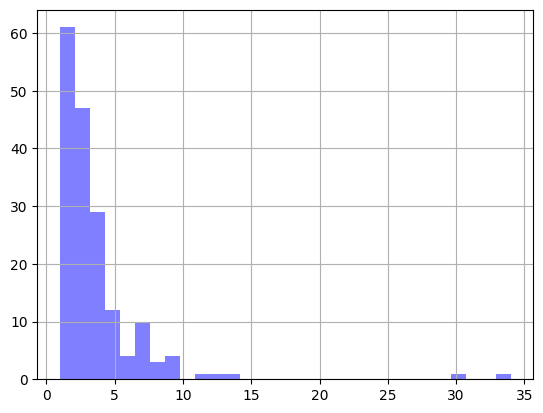

In [162]:
train_df.eo_count.hist(bins=30, alpha=0.5, color='blue', label='Train')


<Axes: >

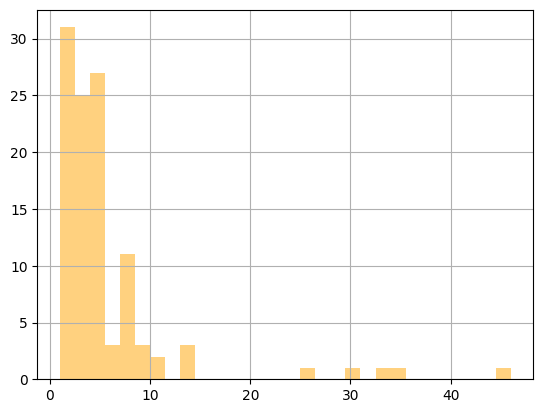

In [135]:
test_df.eo_count.hist(bins=30, alpha=0.5, color='orange', label='Test')


In [163]:
X_train = train_df[features].values.astype(float)
y_train = train_df[target].values
X_test = test_df[features].values.astype(float)
y_test = test_df[target].values

In [164]:


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [165]:


y_train_log = np.log1p(y_train)  # log(1 + y) for train target
y_test_log = np.log1p(y_test)    # same for test target


In [166]:


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)


In [167]:
# Define the model
# model = nn.Sequential(
#     nn.Linear(6, 32),
#     nn.ReLU(),
#     nn.Linear(32, 16),
#     nn.ReLU(),
#     nn.Linear(16, 1)
# )
model = nn.Sequential(
    nn.Linear(8, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)
# model = nn.Sequential(
#     nn.Linear(6, 64),
#     nn.BatchNorm1d(64),
#     nn.ReLU(),
#     nn.Dropout(0.2),

#     nn.Linear(64, 32),
#     nn.BatchNorm1d(32),
#     nn.ReLU(),
#     nn.Dropout(0.2),

#     nn.Linear(32, 16),
#     nn.BatchNorm1d(16),
#     nn.ReLU(),
#     nn.Dropout(0.1),

#     nn.Linear(16, 8),
#     nn.ReLU(),

#     nn.Linear(8, 1)
# )

# Loss and optimizer
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Prepare mini-batch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")





Epoch 0: Loss = 10.8265
Epoch 100: Loss = 1.3636
Epoch 200: Loss = 1.1459
Epoch 300: Loss = 0.9852
Epoch 400: Loss = 0.9616
Epoch 500: Loss = 0.9796
Epoch 600: Loss = 0.9620
Epoch 700: Loss = 0.9110
Epoch 800: Loss = 0.9006
Epoch 900: Loss = 0.8763
Epoch 1000: Loss = 0.9457
Epoch 1100: Loss = 0.8918
Epoch 1200: Loss = 0.8519
Epoch 1300: Loss = 0.8972
Epoch 1400: Loss = 0.8440
Epoch 1500: Loss = 0.8299
Epoch 1600: Loss = 0.8637
Epoch 1700: Loss = 0.8213
Epoch 1800: Loss = 0.7929
Epoch 1900: Loss = 0.7855
Epoch 2000: Loss = 0.8444
Epoch 2100: Loss = 0.7800
Epoch 2200: Loss = 0.8058
Epoch 2300: Loss = 0.7845
Epoch 2400: Loss = 0.7803
Epoch 2500: Loss = 0.7998
Epoch 2600: Loss = 0.8545
Epoch 2700: Loss = 0.7466
Epoch 2800: Loss = 0.7807
Epoch 2900: Loss = 0.7607
Epoch 3000: Loss = 0.7764
Epoch 3100: Loss = 0.8027
Epoch 3200: Loss = 0.7338
Epoch 3300: Loss = 0.7446
Epoch 3400: Loss = 0.7588
Epoch 3500: Loss = 0.7086
Epoch 3600: Loss = 0.7721
Epoch 3700: Loss = 0.7364
Epoch 3800: Loss = 0.75

In [168]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = loss_fn(predictions, y_test_tensor)
    print(f"Final test MSE: {mse.item():.4f}")
    rmse = torch.sqrt(torch.tensor(mse.item()))
    print(f"Test RMSE: {rmse.item():.2f}")


Final test MSE: 0.1257
Test RMSE: 0.35


In [169]:


# Set the model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    preds_log = model(X_test_tensor).squeeze()

# If you used log1p transformation, invert it with expm1
preds = torch.expm1(preds_log).numpy()  # convert log1p back to original scale
actuals = y_test  # y_test should already be in original scale (not log)

# Create the comparison table
results_df = pd.DataFrame({
    'Actual': actuals,
    'Predicted': preds
})

# Optional: Round to 2 decimal places
results_df = results_df.round(2)

# Show the first few rows
print(results_df.tail(20))


    Actual  Predicted
55       1   3.150000
56       3   3.080000
57       8   5.700000
58       3   2.030000
59       2   2.070000
60       1   2.740000
61      10   5.590000
62       1   0.840000
63       2   2.180000
64       2   2.830000
65       3   2.050000
66      46  60.189999
67       2   1.200000
68       2   3.750000
69       1   2.030000
70       2   2.750000
71       3   5.540000
72       2   1.970000
73       5   2.850000
74       4   3.100000


In [170]:
import torch
import numpy as np

model.eval()
with torch.no_grad():
    # Predict on test set (log scale)
    preds_log = model(X_test_tensor)

    # Inverse transform predictions and actual values
    preds_orig = torch.expm1(preds_log).squeeze().numpy()
    actuals_orig = torch.expm1(y_test_tensor).squeeze().numpy()

    # Calculate RMSE on original scale
    rmse_orig = np.sqrt(np.mean((preds_orig - actuals_orig) ** 2))
    print(f"Test RMSE (original scale): {rmse_orig:.4f}")


Test RMSE (original scale): 3.0810


In [171]:
print("Train target range:")
print(f"Min: {y_train.min()}, Max: {y_train.max()}")


print("Test target range:")
print(f"Min: {y_test.min()}, Max: {y_test.max()}")


Train target range:
Min: 1, Max: 34
Test target range:
Min: 1, Max: 46
